<a href="https://colab.research.google.com/github/ovozzx/Machine-Learning/blob/master/%5BXGBoost%5D%EC%9C%84%EC%8A%A4%EC%BD%98%EC%8B%A0_%EC%9C%A0%EB%B0%A9%EC%95%94_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#위스콘신 유방암 예측

- 데이터 : 종양의 크기, 모양 등 → 악성 종양/양성 종양 분류

(데이터는 사이킷런에 내장)

# 1. 파이썬 래퍼 XGBoost

In [ ]:
import xgboost

print(xgboost.__version__)

0.90


In [ ]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer() #딕셔너리 형태
X_features= dataset.data # 가로별?
y_label = dataset.target


cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)



In [ ]:

cancer_df['target']= y_label # 칼럼 추가
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [ ]:
cancer_df.tail()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.256,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.463,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.075,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.595,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,0.3857,1.428,2.548,19.15,0.007189,0.00466,0.00000,0.00000,0.02676,0.002783,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1


In [ ]:
print(dataset.target_names) #malignant : 악성(0), benign : 양성(1)
print(cancer_df['target'].value_counts()) #0과 1 각각 카운트

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [ ]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
                                         test_size=0.2, random_state=156 )
print(X_train.shape , X_test.shape) #(행,열)

(455, 30) (114, 30)


In [ ]:
#💫학습용과 테스트용 데이터 세트를 위해 별도의 객체 DMatrix 만듦 <-> 사이킷런
#DMatrix : XGBoost만의 전용 데이터 세트, 입력 파라미터는 넘파이 등등
dtrain = xgb.DMatrix(data=X_train , label=y_train) #넘파이 형태의 데이터 → DMatrix 변환
dtest = xgb.DMatrix(data=X_test , label=y_test)

In [ ]:
#XGBoost의 하이퍼 파라미터는 주로 딕셔너리 형태로 입력

params = { 'max_depth':3,
           'eta': 0.1, #학습률
           'objective':'binary:logistic', #이진분류이므로 목적함수는 이진 로지스틱
           'eval_metric':'logloss' #오류 함수의 평가 성능 지표
        } 
num_rounds = 400 #부스팅 반복 횟수

In [ ]:
# train 데이터 셋은 ‘train’ , evaluation(test) 데이터 셋은 ‘eval’ 로 명기합니다. 
wlist = [(dtrain,'train'),(dtest,'eval') ]


# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달 <-> 사이킷런
xgb_model = xgb.train(params = params , dtrain=dtrain , num_boost_round=num_rounds , \
                      early_stopping_rounds=100, evals=wlist ) #조기 중단 → evals 파라미터에 eval 데이터 세트 명기 필요!

[0]	train-logloss:0.609688	eval-logloss:0.61352
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.540803	eval-logloss:0.547843
[2]	train-logloss:0.483753	eval-logloss:0.494248
[3]	train-logloss:0.434457	eval-logloss:0.447986
[4]	train-logloss:0.39055	eval-logloss:0.409109
[5]	train-logloss:0.354146	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292593	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245153	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207938	eval-logloss:0.246037
[12]	train-logloss:0.192184	eval-logloss:0.231556
[13]	train-logloss:0.177916	eval-logloss:0.22005
[14]	train-logloss:0.165222	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logl

In [ ]:
#💫파이썬 래퍼 XGBoost의 predict는 확률 값을 반환 <-> 사이킷런의 predict는 결과 클래스 값 반환(0,1)
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장 
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score


def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


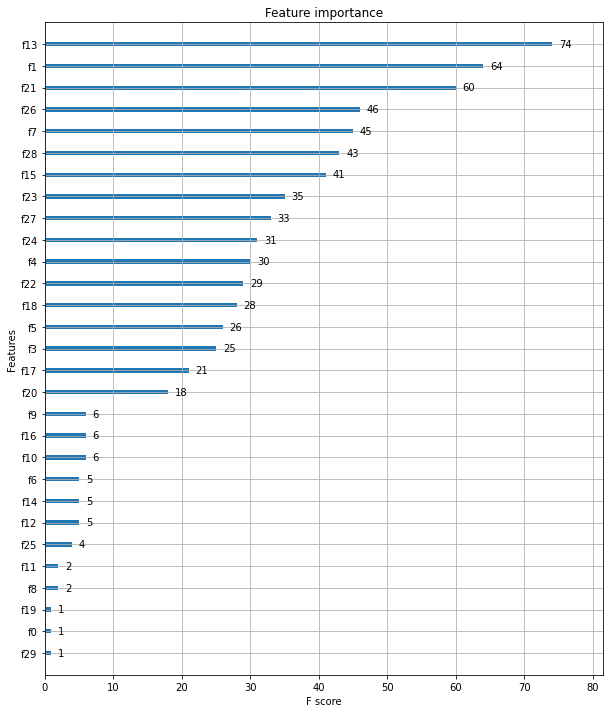

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax) #피처 중요도→막대그래프

#유의 : 피처명 제대로 알 수 없음, 피처 순서별로 f0, f1 이런식!

# 2. 사이킷런 래퍼 XGBoost

XGBClassifier

XGBRegressor

###  ✓ scikit-learn

scikit-learn은 몹시 다양한 분류 모델(classification)를 제공
1. Logistic regression (e.g. LASSO, Ridge, ElasticNet)
2. Support Vector Machine (e.g SVM)
3. K-Nearest Neighbors (e.g KNN)
4. Naive Bayes
5. Decision Tree (e.g Random Forest)
6. Multi-layer perceptron (e.g MLP, Neural Network)

각 분류 모델의 성능을 평가(model selection)할 수 있는 방법들도 함께 제공
1. Accuracy
2. Confusion matrix
3. Precision, Recall and F-measure
4. Receiver operating characteristic (AUC-ROC)

✓predict_proba

scikit-learn 분류기에서 불확실성을 추정할 수 있는 함수

출력은 각 클래스에 대한 확률

predict_proba로 예측한 확률중에서 제일 높은 값을 선택 -> 분류 모델의 에측

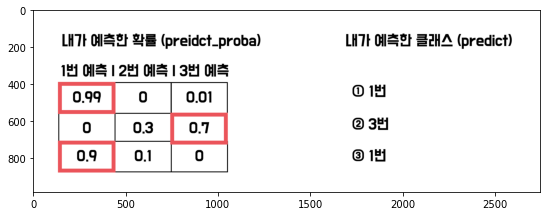

In [26]:
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 

jpgSample = mpimg.imread('스크린샷.png') 


plt.figure(figsize=(20, 15)) 
plt.subplot(2,2,1)
plt.imshow(jpgSample)

사진 출처 : https://velog.io/@skyepodium/logloss-%EC%95%8C%EC%95%84%EB%B3%B4%EA%B8%B0

In [ ]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1] ##??

In [ ]:
w_pred_proba

#전체 테스트 데이터 수의 각각에 대한 확률(0~1)

array([9.50490355e-01, 2.68998020e-03, 9.00371552e-01, 8.60875845e-02,
       9.92675722e-01, 9.99981403e-01, 9.99791086e-01, 9.99481976e-01,
       9.97610450e-01, 6.87922584e-05, 1.33313442e-04, 1.01436293e-04,
       9.99892116e-01, 9.99944687e-01, 9.99167681e-01, 9.92133617e-01,
       9.95427251e-01, 9.99919534e-01, 9.99656677e-01, 9.99604046e-01,
       9.05153283e-04, 6.28991008e-01, 1.15507115e-04, 9.99985456e-01,
       1.54840411e-04, 8.34896803e-01, 3.00992560e-03, 1.53217668e-04,
       9.99544561e-01, 4.84596007e-02, 9.98978972e-01, 2.59790075e-04,
       9.91299808e-01, 8.01291227e-01, 2.66897934e-03, 5.68914729e-05,
       9.99474347e-01, 9.99359906e-01, 3.16480607e-01, 9.99880791e-01,
       2.04391092e-01, 9.98423219e-01, 9.99593914e-01, 9.99798477e-01,
       9.99363601e-01, 9.86984253e-01, 9.24933609e-03, 9.99644876e-01,
       9.99335945e-01, 9.99751031e-01, 9.98809576e-01, 2.15122258e-04,
       9.99518752e-01, 9.99917746e-01, 9.99753892e-01, 9.99451220e-01,
      

In [ ]:
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


✓조기중단

반복 횟수 = early_stopping_rounds

평가 지표 = eval_metric

성능 평가 = eval_set

In [ ]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", 
                eval_set=evals, verbose=True) #조기중단 추가 → 100번 반복 동안 성능 평가 지수가 향상되지 않으면 멈춤

ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

In [ ]:
get_clf_eval(y_test , ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


In [ ]:
# early_stopping_rounds를 10으로 설정하고 재 학습. 
# 조기 중단값을 급격하게 줄이면 예측 성능 저하 우려 큼
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, 
                eval_metric="logloss", eval_set=evals,verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


 ✓plot_importance
 
 피처 중요도 시각화 모듈

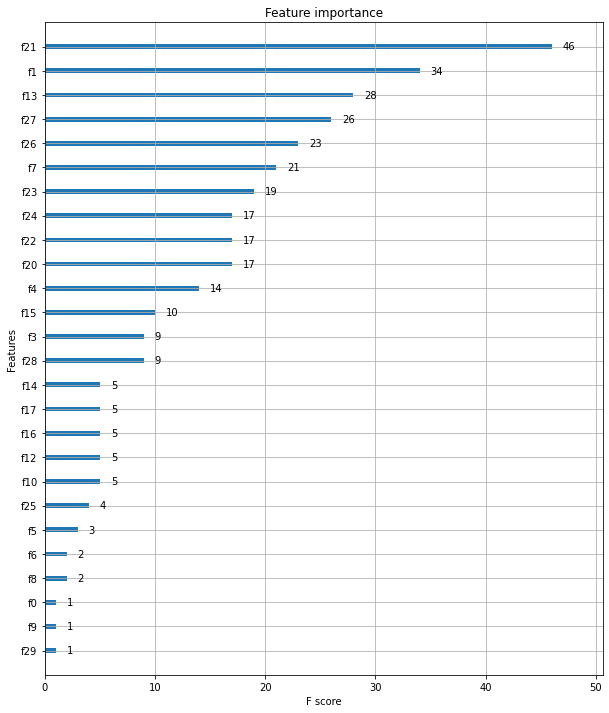

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax) #파이썬 래퍼와 같은 결과 출력